<center>

**_RN y CNN_ MONKEY: CLASIFICACIÓN DE 10 TIPOS DE ESPECIE DE MONOS**

**Conceptos de CNN**

---
Introducción a la Inteligencia Artificial, Código: 3010476

Inteligencia Artificial, Código: 3007855

---
**Monitores:**

Maria Alejandra Muñoz Alarcón

---

Denilson Andres Molina Truyot 

---

</center>

Para este código solo basta con que tengan la carpeta *validation* y *training*, esto lo pueden obtener en el siguiente link: https://www.kaggle.com/datasets/slothkong/10-monkey-species?select=training

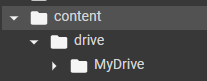

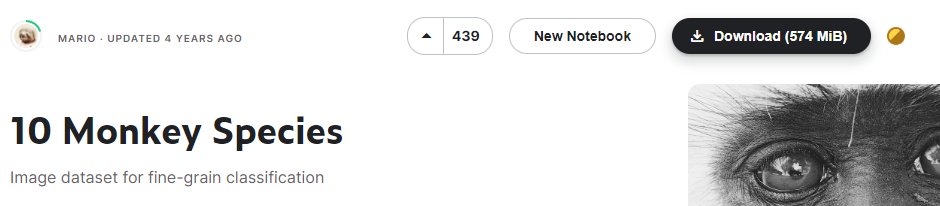


In [ ]:
#Comentar si se usa desde escritorio.
!pip install keras
from google.colab import drive
drive.mount('/content/drive/')    #Acceder a las carpetas training data y validadtion que están desde google drive.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive/


In [ ]:
# Librerias usadas
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
import math
import os
from sklearn.metrics import confusion_matrix
from skimage import io 
from skimage.transform import rescale, resize, downscale_local_mean
from random import randint, choice, choices
from tensorflow import keras
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import cv2
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Activation, BatchNormalization

## Cargar imágenes de entrenamiento.

In [ ]:
#Cargado de imágenes
#Ruta donde esté ubicado el archivo .npy.
X_train = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/X_train.npy', allow_pickle=True)   #Ruta donde esté ubicado el archivo .npy.
y_train = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/y_train.npy', allow_pickle=True)

#Si está en la misma jerarquía de archivos:
#X_train = np.load('./X_train.npy', allow_pickle=True)   #Ruta donde esté ubicado el archivo .npy.
#y_train = np.load('./y_train.npy', allow_pickle=True)


In [ ]:
#Normalizar los vectores
X_train = X_train/255      #255 es el valor en la escala más alta de colores.

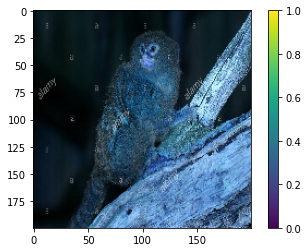

In [ ]:
#Observar las imagenes cargadas
plt.figure()
plt.imshow(X_train[18])
plt.colorbar()
plt.grid(False)
plt.show()

### **Buenas prácticas**
Se sugiere que de los registros de entrada del dataset se guarde un porcentaje para datos de entrenamiento y otro para **prueba (Note que en este dataset ya hay una carpeta de validación, esta carpeta se usará para la validación de las imágenes en el modelo. Por otra parte, las pruebas se usarán para predicción)**.

In [ ]:
# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y_train)

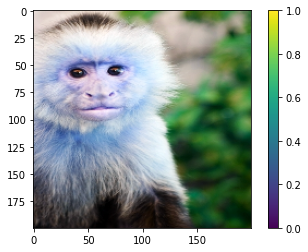

In [ ]:
#Observar las imágenes de prueba cargadas.
plt.figure()
plt.imshow(X_test[18])
plt.colorbar()
plt.grid(False)
plt.show()

## Cargar imágenes de Validación (No es lo mismo que prueba)

In [ ]:
#Cargado de las imagenes de validación.
#Ruta donde esté ubicado el archivo .npy.
X_valid = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/X_valid.npy', allow_pickle=True)
y_valid = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/y_valid.npy', allow_pickle=True)

#En escritorio.
#X_valid = np.load('./X_valid.npy', allow_pickle=True)
#y_valid = np.load('./y_valid.npy', allow_pickle=True)


In [ ]:
#Normalizar los vectores
X_valid = X_valid/255.0

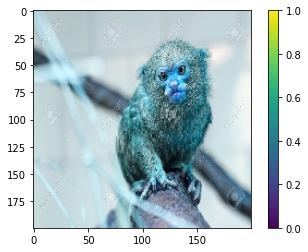

In [ ]:
#Observar las imagenes cargadas de validación
plt.figure()
plt.imshow(X_valid[18])
plt.colorbar()
plt.grid(False)
plt.show()

## Declaración de labels y análisis de datos

*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.

*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

**Clasifiación de especies de monos**:

<center>

|Label|Nombre De Especies|
|-----|------------------|
|0|alouatta_palliata|
|1|erythrocebus_patas|
|2|cacajao_calvus|
|3|macaca_fuscata|
|4|cebuella_pygmea|
|5|cebus_capucinus|
|6|mico_argentatus|
|7|saimiri_sciureus|
|8|aotus_nigriceps|
|9|trachypithecus_johnii|


</center>

In [ ]:
#Nombre de las especies de monos a clasificar
names=['alouatta_palliata','erythrocebus_patas','cacajao_calvus','macaca_fuscata','cebuella_pygmea','cebus_capucinus',
'mico_argentatus','saimiri_sciureus','aotus_nigriceps','trachypithecus_johnii']
print(len(names))

10


### Datos que suelen ser de importancia: Dimensión de las imágenes cargadas.

In [ ]:
#Muestra de como están las imagenes
X_train.shape

(878, 200, 200, 3)

## Sugerencias para la optimización de modelos de CNN.
Usando [tf.keras](https://www.tensorflow.org/guide/keras), una API de alto nivel para construir y entrenar modelos en TensorFlow.

### Red convolucional inicial.
Se usará el modelo secuencial de keras. Además, se va a extraer la información más representativa de las imagenes por medio de filtros dados por capas convolucionales para poder clasificar las distintas especies con su respectivo label.

**MODELO:**
Las 6 líneas de código a continuación definen la base convolucional usando un patrón común: una pila de capas [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) y [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

Como entrada, una CNN toma tensores de forma (image_height, image_width, color_channels), ignorando el tamaño del lote (batch_size). En este ejemplo, se configura la CNN para procesar entradas de forma (200, 200, 3), que es el formato de las imágenes especies de monos. Se puede hacer esto pasando el argumento `input_shape` en la primera capa o añadiendo una capa llamada Input donde se indique las dimensiones de las imágenes (La tercera componente del tamaño corresponde a los canales de color RGB que forman la imagen).

Una de las ventajas de las CNN sobre las NN es que no es necesario "aplanar" las imágenes de entrada a una sola dimensión. Esto ayuda a conservar las propiedades espaciales de las imágenes y a controlar la cantidad de parámetros entrenables.

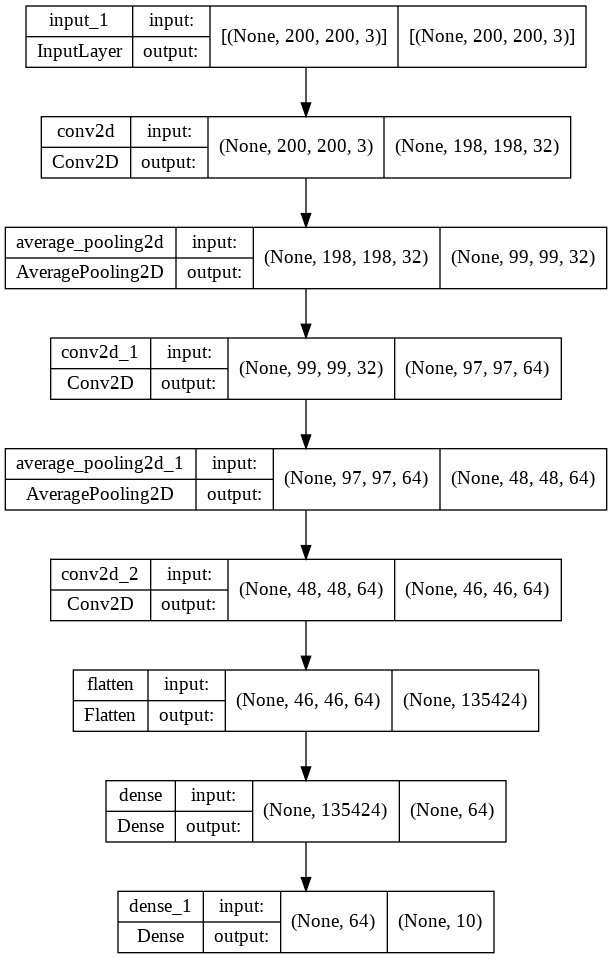

In [ ]:
model_CNN = keras.Sequential([
    keras.layers.Input(shape=(200,200,3)),      
    #Caracterizacion de las imagenes
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), 
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),   


    #Etapa de clasificacion
    keras.layers.Flatten(),     #Aplanar los datos a un vector unidimensional
    keras.layers.Dense(64, activation=tf.nn.relu),#Implementza la operación f(z)
    
    keras.layers.Dense(len(names), activation=tf.nn.softmax)
])
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

Arriba, se puede ver que la salida de cada capa Conv2D y MaxPooling2D es un tensor de forma 3D (alto, ancho, canales). Las dimensiones de ancho y alto tienden a encogerse a medida que avanza en la red. El número de canales de salida para cada capa Conv2D se controla mediante el primer argumento (por ejemplo, 32 o 64). Por lo general, a medida que el ancho y la altura se reducen, puede permitirse (computacionalmente) agregar más canales de salida en cada capa Conv2D.

**Agregar capas densas en la parte final de la red**


Para completar el modelo, se introducirá el último tensor de salida de la base convolucional (de forma (4, 4, 64)) en una o más capas densas (completamente conectadas) para realizar la clasificación. Las capas densas toman vectores como entrada (que son 1D), mientras que la salida que se tiene hasta el momento es un tensor 3D. Primero, se debe aplanar (o desenrollar) la salida 3D a 1D, luego se agrega una o más capas densas en la parte superior. CIFAR tiene 10 clases de salida, por lo que usa una capa Densa final con 10 salidas.

#### Arquitectura del modelo y cantidad de parámetros.

Siempre hay que tener en cuenta la cantidad de parámetros P que se van a variar ya que estos se cambian con esta permutación:

<center>

Número de variaciones totales = $2*P*epochs$

</center>

$2*P$ = Número de variaciones hacia adelante + número de variaciones hacia atrás.

In [ ]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 135424)            0

#### **PROCESAMIENTO DEL MODELO**.
Deben estar atentos al tiempo estimado para acabar una época: **ETA**.

In [ ]:
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Relu: Da mejores resultados de exactitud
print("RELU")
history_relu = model_CNN.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=12)
print("======")
#El modelo se entrena y guarda los resultados, es decir, si paran el código y lo corren de nuevo, se quedan en la corrida
#donde estaban.


RELU
Epoch 1/12
28/28 [==============================] - 14s 74ms/step - loss: 2.3439 - accuracy: 0.1401 - val_loss: 2.2438 - val_accuracy: 0.1324
Epoch 2/12
28/28 [==============================] - 1s 54ms/step - loss: 1.9600 - accuracy: 0.3018 - val_loss: 1.8548 - val_accuracy: 0.3309
Epoch 3/12
28/28 [==============================] - 1s 48ms/step - loss: 1.4936 - accuracy: 0.4954 - val_loss: 2.0607 - val_accuracy: 0.3493
Epoch 4/12
28/28 [==============================] - 1s 48ms/step - loss: 1.1943 - accuracy: 0.6036 - val_loss: 1.5581 - val_accuracy: 0.5184
Epoch 5/12
28/28 [==============================] - 1s 48ms/step - loss: 0.8669 - accuracy: 0.7164 - val_loss: 1.5837 - val_accuracy: 0.4926
Epoch 6/12
28/28 [==============================] - 1s 48ms/step - loss: 0.5818 - accuracy: 0.8132 - val_loss: 1.6016 - val_accuracy: 0.5294
Epoch 7/12
28/28 [==============================] - 2s 59ms/step - loss: 0.3402 - accuracy: 0.8952 - val_loss: 1.5763 - val_accuracy: 0.5441
Epoch 8

#### Gráfico de exactitud.

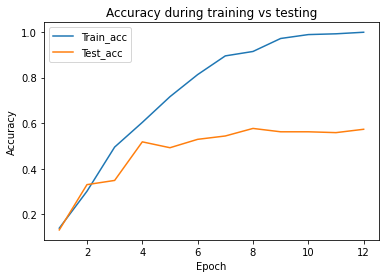

In [ ]:
history_dict=history_relu.history
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, history_dict["accuracy"])
plt.plot(epochs, history_dict["val_accuracy"])
plt.legend(["Train_acc", "Test_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training vs testing")
plt.show()

#### Gráfico de la función de pérdida

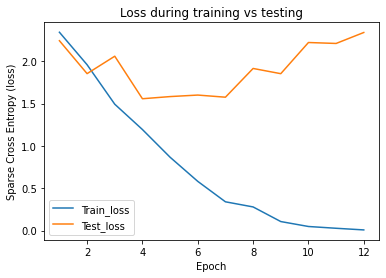

In [ ]:
plt.plot(epochs, history_dict["loss"])
plt.plot(epochs, history_dict["val_loss"])
plt.legend(["Train_loss", "Test_loss"])
plt.xlabel("Epoch")
plt.ylabel("Sparse Cross Entropy (loss)")
plt.title("Loss during training vs testing")
plt.show()

#### Conclusión:

Es aquí donde, mientras más conceptos claros se tengan de cómo formar una red, más ahorro de tiempo se tendrá en la ejecución y procesamiento de un modelo.

### EJERCICIO DE PRÁCTICA.
Observamos que existe un problema de overfitting en un 40%. Se tiene la hipótesis de que si se tienen más porcentaje de datos de validación disminuye el porcentaje anterior. Testee lo anterior implementando con OTRO patrón de capas.

In [ ]:
#Los datos que se tienen de validación pasarán a ser los de prueba
X_test=X_valid
y_test=y_valid

# De las imágenes de entrenamiento, dividimos 60% para el entrenamiento del modelo y 40% para validación.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    test_size = 0.40, #60% datos de entrenamiento, 40% validacion
                                                    stratify = y_train)

In [ ]:
#Corroborar que sí se realizó la subdivisión correctamente
print("Datos de entrenamiento:",X_train.shape,"; Datos de validación:",X_valid.shape,"; Datos de prueba:",X_test.shape)

Datos de entrenamiento: (526, 200, 200, 3) ; Datos de validación: (352, 200, 200, 3) ; Datos de prueba: (272, 200, 200, 3)


<center>

Pueden testear distintas variaciones de porcentajes sí desean.

---
51% de imágenes.
*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.

---

---
34% de imágenes.
*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

---

---
15% de imágenes.
*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

---
</center>

#### Prueba con el modelo anterior.

In [ ]:
#Otra forma de declarar el modelo
model_CNN = keras.Sequential([
    keras.layers.Input(shape=(200,200,3)),      #Se van a recibir imagenes con estas entradas.
    #Caracterizacion de las imagenes
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), #32 mapeos/neuronas de características representativas
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),     #¿Qué pasa con 128 o 256 neuronas o perceptrones?
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),   
    #keras.layers.Conv2D(128, (3, 3), activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Etapa de clasificacion
    keras.layers.Flatten(),     #Aplanar los datos a un vector unidimensional
    keras.layers.Dense(64, activation=tf.nn.relu),#Implementza la operación f(z)
    #keras.layers.Dropout(0.5),      #¿Qué pasa si disminuyo/aumento el porcentaje de peceptrones analizados?
    keras.layers.Dense(len(names), activation=tf.nn.softmax)
])
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Relu: Da mejores resultados de exactitud en este caso, hay que testear con otras funciones de activación.
history_relu = model_CNN.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=9)


Epoch 1/9
17/17 [==============================] - 2s 80ms/step - loss: 2.7335 - accuracy: 0.1198 - val_loss: 2.2507 - val_accuracy: 0.1023
Epoch 2/9
17/17 [==============================] - 1s 60ms/step - loss: 2.0177 - accuracy: 0.2852 - val_loss: 1.8933 - val_accuracy: 0.3210
Epoch 3/9
17/17 [==============================] - 1s 60ms/step - loss: 1.5752 - accuracy: 0.4582 - val_loss: 1.6513 - val_accuracy: 0.4318
Epoch 4/9
17/17 [==============================] - 1s 60ms/step - loss: 1.0864 - accuracy: 0.6369 - val_loss: 1.8077 - val_accuracy: 0.3977
Epoch 5/9
17/17 [==============================] - 1s 60ms/step - loss: 0.8641 - accuracy: 0.7376 - val_loss: 1.6505 - val_accuracy: 0.4233
Epoch 6/9
17/17 [==============================] - 1s 61ms/step - loss: 0.6618 - accuracy: 0.7757 - val_loss: 1.7169 - val_accuracy: 0.4574
Epoch 7/9
17/17 [==============================] - 1s 55ms/step - loss: 0.3285 - accuracy: 0.8954 - val_loss: 2.0985 - val_accuracy: 0.4858
Epoch 8/9
17/17 [===

El problema de overfitting sigue ocurriendo con el modelo inicial, además el valor de la función de error aumentó para validación.

**EJERCICIO: Buscar otra secuencia de capas y probarlo con la división de datos inicial y la anterior. ¿El Overfitting es causado por el modelo o por los datos ?. Justifique su respuesta.**

##### *En el caso de **reducir en un 10% el overfitting**, se darán algunos (UNO, no ambos) incentivos.*
 1. +0.3 en la nota del MP4 (Se aumenta la nota individualmente). 
 2. Cambiar la nota de *Una tarea faltante* (en el caso de obtener 5.0 en la nota del MP4).


**No se permiten códigos extraídos de internet, debe explicar su propio modelo (Explicar las capas implementadas) y por qué se redujo el overfitting. ENTREGA: Un archivo .ipynb SOLAMENTE (Código + Justificación) con la solución (No enviar los datasets). En el mismo link de la tarea: https://minaslap.net/mod/assign/view.php?id=24411.**

# **FECHA DE CIERRE: 18/11/2022 a las 11:59 pm**


---
<center>

## **TALLER 7_2: Aplicaciones básicas de visión por computador. Transformaciones de imágenes.**

</center>

---

In [ ]:
#Se cargarán nuevamente los datos ya que no hubo mejoras en el overfitting.
X_train = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/X_train.npy', allow_pickle=True)   #Ruta donde esté ubicado el archivo .npy.
y_train = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/y_train.npy', allow_pickle=True)
#X_train = np.load('./X_train.npy', allow_pickle=True)   #Ruta donde esté ubicado el archivo .npy.
#y_train = np.load('./y_train.npy', allow_pickle=True)
X_train=X_train/255     #Normalización de los datos.

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y_train)

#Datos de validación.
X_valid = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/X_valid.npy', allow_pickle=True)
y_valid = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/y_valid.npy', allow_pickle=True)
#X_valid = np.load('./X_valid.npy', allow_pickle=True)
#y_valid = np.load('./y_valid.npy', allow_pickle=True)
X_valid=X_valid/255   #Normalización de los datos

### Balanceo de clases.
En la práctica, sobre todo en clasificación, se busca una cantidad de datos equitativa. Para el caso particular de imágenes, en el proceso de recolección de datos, se busca desde antes que la cantidad de pictures por clases sean lo más homogenea posibles. Esto es para evitar usar operaciones de transformación que suelen ser propensos a crear más over fitting en el modelo.

Sin embargo, depende del contexto, muchas veces no se cuentan con clases balanceadas, para ello existen operaciones de duplicación de datos o compensación de estas, como se verán acontinuación.

Para solucionar el problema de balanceo de clases, se parte desde la idea explicada en el cuaderno del estudiante Nicolas: " *para solucionar este problema se calculará el peso de importancia de cada clase, de tal manera que entre más imágenes posea una clase con respecto a las demás, menos peso de importancia tendrá dicha clase. Estos pesos serán usados durante el proceso de entrenamiento para prestarle más atención a las imágenes de las clases subrepresentadas.*"

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=(0,1,2,3,4,5,6,7,8,9),   #Levels de los labels usados.
                                     y=y_train)                       #Conjunto de labels de los datos de entrenamiento

In [ ]:
#¿Qué hay en class_weights?
class_weights

#Recuerde que los pesos son ponderados y son afectados principalmente por el label que tiene más recurrencia.
#Si los valores son cercanos a 1, no es necesario balancear.

array([1.0452381 , 0.98651685, 0.99772727, 0.90515464, 1.0452381 ,
       0.97555556, 1.03294118, 0.96483516, 1.03294118, 1.03294118])

Observemos si hay diferencias entre la convergencia del valor de la exactitud para datos de entrenamiento y validación usando los pesos y sin utilizarlos.

In [ ]:
#Se recarga la arquitectura del modelo convolucional.
model_CNN = keras.Sequential([
    keras.layers.Input(shape=(200,200,3)), 
    #Caracterizacion de las imagenes
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),    
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),   

    #Etapa de clasificacion
    keras.layers.Flatten(),     #Aplanar los datos a un vector unidimensional
    keras.layers.Dense(64, activation=tf.nn.relu),#Implementza la operación f(z)
    keras.layers.Dense(len(names), activation=tf.nn.softmax)
])
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Relu: Da mejores resultados de exactitud en este caso, hay que testear con otras funciones de activación.
history_relu = model_CNN.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=9)

Epoch 1/9
28/28 [==============================] - 2s 59ms/step - loss: 2.3729 - accuracy: 0.1458 - val_loss: 2.1705 - val_accuracy: 0.2243
Epoch 2/9
28/28 [==============================] - 1s 49ms/step - loss: 1.9548 - accuracy: 0.3018 - val_loss: 1.7318 - val_accuracy: 0.3934
Epoch 3/9
28/28 [==============================] - 1s 49ms/step - loss: 1.5931 - accuracy: 0.4487 - val_loss: 1.8286 - val_accuracy: 0.3676
Epoch 4/9
28/28 [==============================] - 1s 48ms/step - loss: 1.2070 - accuracy: 0.6002 - val_loss: 1.4113 - val_accuracy: 0.5404
Epoch 5/9
28/28 [==============================] - 1s 49ms/step - loss: 0.7858 - accuracy: 0.7472 - val_loss: 1.2965 - val_accuracy: 0.5404
Epoch 6/9
28/28 [==============================] - 1s 49ms/step - loss: 0.4507 - accuracy: 0.8519 - val_loss: 1.5955 - val_accuracy: 0.5221
Epoch 7/9
28/28 [==============================] - 1s 49ms/step - loss: 0.2682 - accuracy: 0.9180 - val_loss: 1.4362 - val_accuracy: 0.5846
Epoch 8/9
28/28 [===

**USANDO BALANCEO**

¿Nos benefició usar balanceo o no?

In [ ]:
#Se recarga la arquitectura del modelo convolucional.
model_CNN = keras.Sequential([
    keras.layers.Input(shape=(200,200,3)), 
    #Caracterizacion de las imagenes
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),    
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),   

    #Etapa de clasificacion
    keras.layers.Flatten(),     #Aplanar los datos a un vector unidimensional
    keras.layers.Dense(64, activation=tf.nn.relu),#Implementza la operación f(z)
    keras.layers.Dense(len(names), activation=tf.nn.softmax)
])
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Relu: Da mejores resultados de exactitud en este caso, hay que testear con otras funciones de activación.
history_relu = model_CNN.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    class_weight=dict(enumerate(class_weights)),    #Uso de balanceo.
                    epochs=9)

Epoch 1/9
28/28 [==============================] - 2s 70ms/step - loss: 2.4290 - accuracy: 0.1515 - val_loss: 2.1507 - val_accuracy: 0.1544
Epoch 2/9
28/28 [==============================] - 2s 57ms/step - loss: 2.0977 - accuracy: 0.2084 - val_loss: 1.9855 - val_accuracy: 0.2426
Epoch 3/9
28/28 [==============================] - 1s 50ms/step - loss: 1.6901 - accuracy: 0.4169 - val_loss: 2.3405 - val_accuracy: 0.3088
Epoch 4/9
28/28 [==============================] - 1s 49ms/step - loss: 1.3802 - accuracy: 0.5216 - val_loss: 1.5863 - val_accuracy: 0.4412
Epoch 5/9
28/28 [==============================] - 2s 54ms/step - loss: 1.1175 - accuracy: 0.6253 - val_loss: 1.7995 - val_accuracy: 0.4265
Epoch 6/9
28/28 [==============================] - 1s 49ms/step - loss: 0.7857 - accuracy: 0.7563 - val_loss: 1.6521 - val_accuracy: 0.4596
Epoch 7/9
28/28 [==============================] - 1s 49ms/step - loss: 0.4602 - accuracy: 0.8656 - val_loss: 1.8056 - val_accuracy: 0.4779
Epoch 8/9
28/28 [===

### Callbacks.
Basado en el cuaderno de la conferencia de Transferencia de aprendizaje, lo siguiente expresará el concepto de *callback*: " *Utilidad para crear **callbacks** para realizar automáticamente los siguientes procesos durante el entrenamiento del modelo: almacenar métricas de entrenamiento.

Realizar parada anticipada (*early stopping*), **almacenar el mejor modelo**, reducir la tasa de aprendizaje (*learning rate*) cuando el aprendizaje del modelo se estanque y guardar registros para posteriormente ser visualizados mediante TensorBoard [[4]](https://keras.io/api/callbacks/).* "

In [ ]:
#Librerias necesarias para el uso de callbacks
from pathlib import Path
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

def create_callbacks(output_dirs, model_name, stopping_patience, lr_patience, initial_lr):

    # Asegura que las carpetas donde se almacenarán las salidas de los "callbacks" estén creadas.
    for output_dir in output_dirs.values():

        Path(output_dir).mkdir(parents=True, exist_ok=True)

    csv_logger = CSVLogger(os.path.join(output_dirs["/training_metrics"], f"{model_name}.csv"))
    early_stopping = EarlyStopping(patience=stopping_patience, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(os.path.join(output_dirs["/models"], f"{model_name}.hdf5"),
        verbose=1,
        save_best_only=True
    )

    # Reduce la tasa de aprendizaje a la mitad (como máximo 5 veces) en caso de no haber 
    # mejora durante varios "epochs".
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=lr_patience, min_lr=initial_lr * (0.5 ** 5))

    timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
    tensorboard = TensorBoard(
        os.path.join(output_dirs["/tensorboard_logs"], f'{model_name}_{timestamp}'),
        histogram_freq=1,
        write_images=True,
        write_steps_per_second=True,
        profile_batch=(10, 20)
    )

    return csv_logger, early_stopping, model_checkpoint, reduce_lr, tensorboard

In [ ]:
#Deficion de callbacks.
#Hay que crear las carpetas training_metrics, models y tensorboard_logs antes de correr el código.
OUTPUT_DIRS = {
    #Para escritorio. Atentos a la jerarquía de archivos.
    #"/training_metrics": "./outputs/training_metrics",
    #"/models": "./outputs/models",
    #"/tensorboard_logs": "./outputs/tensorboard_logs"

    #Donde tengan creadas estas carpetas en su drive. OJO que solo cambió el valor del diccionario.
    "/training_metrics": "./content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/outputs/training_metrics",
    "/models": "./content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/outputs/models",
    "/tensorboard_logs": "./content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/outputs/tensorboard_logs"
}

MODEL_NAME = "model_classMonkeays_v0"      #Nombre del modelo
STOPPING_PATIENCE = 16  # Cantidad de "epochs" sin mejora para detener el entrenamiento.
LR_PATIENCE = 8  # Cantidad de "epochs" sin mejora para reducir la tasa de aprendizaje.
INITIAL_LR = 0.0001

callbacks = create_callbacks(OUTPUT_DIRS, MODEL_NAME, STOPPING_PATIENCE,
                             LR_PATIENCE, INITIAL_LR)

In [ ]:
#Nombre de las especies de monos a clasificar
names=['alouatta_palliata','erythrocebus_patas','cacajao_calvus','macaca_fuscata','cebuella_pygmea','cebus_capucinus',
'mico_argentatus','saimiri_sciureus','aotus_nigriceps','trachypithecus_johnii']

#Uso del callback y balanceo
model_CNN = keras.Sequential([
    keras.layers.Input(shape=(200,200,3)),     
    #Caracterizacion de las imagenes
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), 
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),   

    #Etapa de clasificacion
    keras.layers.Flatten(),     #Aplanar los datos a un vector unidimensional
    keras.layers.Dense(64, activation=tf.nn.relu),#Implementza la operación f(z)
    #keras.layers.Dropout(0.5),      #¿Qué pasa si disminuyo/aumento el porcentaje de peceptrones analizados?
    keras.layers.Dense(len(names), activation=tf.nn.softmax)
])
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Relu: Da mejores resultados de exactitud en este caso, hay que testear con otras funciones de activación.
history_relu = model_CNN.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    class_weight=dict(enumerate(class_weights)),    #Uso de balanceo.
                    callbacks=callbacks,        #Uso del callback.
                    epochs=9)

Epoch 1/9
28/28 [==============================] - ETA: 0s - loss: 2.5081 - accuracy: 0.1105
Epoch 1: val_loss improved from inf to 2.21387, saving model to ./content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/outputs/models/model_classMonkeays_v0.hdf5
28/28 [==============================] - 6s 218ms/step - loss: 2.5081 - accuracy: 0.1105 - val_loss: 2.2139 - val_accuracy: 0.1176 - lr: 0.0010
Epoch 2/9
28/28 [==============================] - ETA: 0s - loss: 1.9614 - accuracy: 0.3098
Epoch 2: val_loss improved from 2.21387 to 1.77787, saving model to ./content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/outputs/models/model_classMonkeays_v0.hdf5
28/28 [==============================] - 4s 148ms/step - loss: 1.9614 - accuracy: 0.3098 - val_loss: 1.7779 - val_accuracy: 0.3713 - lr: 0.0010
Epoch 3/9
28/28 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.4579
Epoch 3: val_loss improve

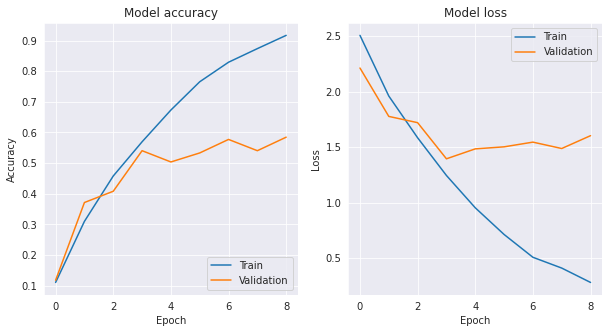

In [ ]:
#Uso de gráficos para métricas a partir de los datos creados por los callbacks.
import seaborn as sb
def plot_learning_curves(training_metrics_csv_path):

    training_metrics = pd.read_csv(training_metrics_csv_path)

    with sb.axes_style("darkgrid"):
        
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Precisión ("accuracy").
        ax1.plot(training_metrics["accuracy"])
        ax1.plot(training_metrics["val_accuracy"])
        ax1.set(title="Model accuracy", xlabel="Epoch", ylabel="Accuracy")
        ax1.legend(("Train", "Validation"), loc="lower right")

        # Pérdida ("loss").
        ax2.plot(training_metrics["loss"])
        ax2.plot(training_metrics["val_loss"])
        ax2.set(title="Model loss", xlabel="Epoch", ylabel="Loss")
        ax2.legend(("Train", "Validation"), loc="upper right")

plot_learning_curves(os.path.join(OUTPUT_DIRS["/training_metrics"], f"{MODEL_NAME}.csv"))

A la hora de analizar la exactitud tenga presente la siguiente idea: *Aunque lo anterior es una buena señal, la mejor estimación del rendimiento que tendrá un modelo al enfrentarse a imágenes del "mundo real" se determina usando el conjunto de prueba, ya que este está compuesto de imágenes que no han sido usadas durante el proceso de entrenamiento.*

In [ ]:
#Libreria necesaria para cargar el modelo
from keras.models import load_model, Model

#Se aprovecha el uso del callback para cargar nuestro modelo entrenado
model_CNN = load_model(os.path.join(OUTPUT_DIRS["/models"], f"{MODEL_NAME}.hdf5"))

Como hay forma de usar el modelo entrenado, puedo cargarlo y realizarle el análisis de rendimiento con las imágenes de prueba.

Confusion Matrix


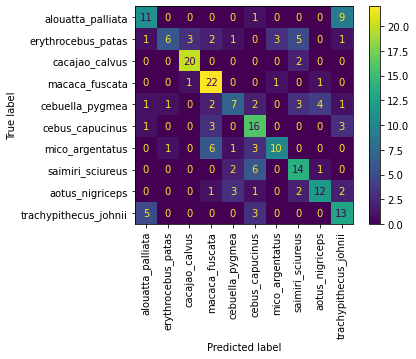

In [ ]:
#Datos de prueba.
predictions=model_CNN.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=names)
disp.plot(xticks_rotation='vertical', values_format='d')

In [ ]:
#Datos de prueba
predictions=model_CNN.predict(X_test)
decoded_predictions = predictions.argmax(axis=1)

print(f'Reporte de clasificación:')
print(classification_report(y_test,decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.69      0.50      0.58        22
           2       1.00      0.77      0.87        22
           3       0.59      0.64      0.62        25
           4       0.40      0.67      0.50        21
           5       0.87      0.57      0.68        23
           6       0.59      0.81      0.68        21
           7       0.53      0.35      0.42        23
           8       0.61      0.52      0.56        21
           9       0.67      0.76      0.71        21

    accuracy                           0.64       220
   macro avg       0.67      0.64      0.64       220
weighted avg       0.67      0.64      0.64       220



### ImageDataGenerator.
Son un conjunto de **transformaciones** aplicadas principalmente para problemas de Visión por computador donde se busca que el modelo aprenda a identificar clases a partir de imágenes *sucias* (Con ruido, rotadas, con poca luz, etc). Para ello, existen un conjunto de transformaciones que pueden realizarse al data set de datos de entrenamiento y eso con lleva a aumentar el número de imágenes de este. Por ende, se sugiere también realizar generación de imágenes tanto para el proceso de entrenamiento como validación.

*En las siguientes subsecciones se presentan las transformaciones que se le aplicarán aleatoriamente a las imágenes del conjunto de entrenamiento con el fin de aumentar el tamaño de este. Cabe mencionar que algunas de dichas transformaciones afectarán la calidad de las imágenes, no obstante, esto es beneficioso para la CNN ya que esta aprenderá a hacer predicciones también en imágenes de baja calidad*.

In [ ]:
#Tener en cuenta dónde se están guardando los datasets
X_train.shape

(878, 200, 200, 3)

In [ ]:
#Libreria para ImageDataGenerator.
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

#Se necesitan definir algunos valores que serán constantes a la hora de aplicar las transformaciones.


#Las constantes suelen escribirse en MAYÚSCULAS.
#HORIZONTAL_FLIP = True     Analizar si para el contexto de su problema, es necesario aprender las imágenes alreves. 
GAUSSIAN_NOISE_VARIANCE_RANGE = 0.01  # Rango de la varianza del ruido gaussiano.
CLASS_NAMES=names           #Nombre de los labels de sus clases.

#### Rotación.
*El ángulo (en grados) en el que se rota una imagen se muestrea de la distribución uniforme $U(-30, 30)$.*

In [ ]:
ROTATION_RANGE = 30
#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        #width_shift_range=channel_shift_range=,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')
i = 0
num_image=5        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente

#### Cambio de brillo.
El valor de cambio de brillo de una imagen se muestrea de la distribución uniforme $U(0.5, 1.5)$. El cambio de brillo de cada pixel se realiza al multiplicar la intensidad de sus canales por el valor muestreado.

In [ ]:
BRIGHTNESS_RANGE = (0.5, 1.5)
#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #width_shift_range=channel_shift_range=,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')


i = 0
num_image=2        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente


#### Inclinación.
*El ángulo (en grados) de cizallamiento que se le aplica a una imagen se muestrea de la distribución uniforme $U(-30, 30)$*.

In [ ]:
SHEAR_RANGE = 30.0
#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #height_shift_range=0.2,
        shear_range=SHEAR_RANGE,
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')

i = 0
num_image=5        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente

#### Cambio de intensidad.
*El valor de cambio de intensidad de una imagen se muestrea de la distribución uniforme $U(-50, 50)$. El cambio de intensidad de cada pixel se realiza al sumarle a la intensidad de sus canales el valor muestreado.*

In [ ]:
CHANNEL_SHIFT_RANGE = 10                #Aparece en negro la imagen. Siempre revisar las imagenes nuevas para que no
                                        #se esté mal entrenando el modelo.
#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #height_shift_range=0.2,
        shear_range=SHEAR_RANGE,
        channel_shift_range=CHANNEL_SHIFT_RANGE,
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')

i = 0
num_image=5        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',                        
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente

#### Adición de Desenfoque Gaussiano
*La desviación estándar del desenfoque gaussiano que se le aplica a una imagen se muestrea de la distribución uniforme $U(0, 1)$.*

In [ ]:
#librerias necesarias
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from skimage.filters import gaussian
from skimage.util import random_noise

#La aplicación de esta transformación viene del siguiente método
def apply_custom_transformations(image, gaussian_blur_sigma_range=0.0, gaussian_noise_variance_range=0.0,
                                 apply_resnet50_preprocessing=False):

    transformed_image = image

    if gaussian_blur_sigma_range:

        # Adición de desenfoque gaussiano.
        sigma = np.random.uniform(0.0, gaussian_blur_sigma_range)
        transformed_image = gaussian(transformed_image, sigma=sigma)

    if gaussian_noise_variance_range:

        # Adición de ruido gaussiano.
        variance = np.random.uniform(0.0, gaussian_noise_variance_range)
        transformed_image = transformed_image.astype("uint8")
        transformed_image = random_noise(transformed_image, var=variance) * 255.0
        transformed_image = transformed_image.astype(image.dtype)
    
    if apply_resnet50_preprocessing:

        # Preprocesamiento requerido por ResNet50.
        transformed_image = preprocess_input(transformed_image)
    
    return transformed_image

GAUSSIAN_BLUR_SIGMA_RANGE = 1.0  # Rango de la desviación estándar del desenfoque gaussiano.

#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #height_shift_range=0.2,
        shear_range=SHEAR_RANGE,
        #channel_shift_range=CHANNEL_SHIFT_RANGE,        
        preprocessing_function=lambda image: apply_custom_transformations(
            image, gaussian_blur_sigma_range=GAUSSIAN_BLUR_SIGMA_RANGE
        ),
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')

i = 0
num_image=5        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  app.launch_new_instance()


#### Combinación de transformaciones.

*La aplicación de la combinación de las transformaciones presentadas anteriormente en el conjunto de entrenamiento produce las imágenes con las cuales finalmente se entrenará la CNN.*

In [ ]:
GAUSSIAN_BLUR_SIGMA_RANGE = 1.0  # Rango de la desviación estándar del desenfoque gaussiano.
GAUSSIAN_NOISE_VARIANCE_RANGE = 0.01  # Rango de la varianza del ruido gaussiano.

#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #height_shift_range=0.2,
        shear_range=SHEAR_RANGE,
        #channel_shift_range=CHANNEL_SHIFT_RANGE,        
        preprocessing_function=lambda image: apply_custom_transformations(
            image, gaussian_blur_sigma_range=GAUSSIAN_BLUR_SIGMA_RANGE,
            gaussian_noise_variance_range=GAUSSIAN_NOISE_VARIANCE_RANGE
        ),
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')

i = 0
num_image=5        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  app.launch_new_instance()


### Aplicación de *Image Data Generator*.
Ya observamos como generar las imágenes con la librería anterior. Ahora se realizará lo siguiente (Esto enfocado en **disminuir** el overfitting).

1. Se agregarán y cargarán 60 imágenes transformadas para el dataset de entrenamiento y validación.
2. Del dataset de entrenamiento se usará 65% para entrenar el modelo y 35% para validar los datos y el dataset de validación será usado para datos de prueba.

In [ ]:
#Cargar las imágenes que se tienen hasta el momento.
#Se cargarán nuevamente los datos ya que no hubo mejores en el overfitting.
X_train = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/X_train.npy', allow_pickle=True)   #Ruta donde esté ubicado el archivo .npy.
y_train = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/y_train.npy', allow_pickle=True)
#X_train = np.load('./X_train.npy', allow_pickle=True)   #Ruta donde esté ubicado el archivo .npy.
#y_train = np.load('./y_train.npy', allow_pickle=True)
X_train=X_train/255     #Normalización de los datos.

# Dividimos los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y_train)

#Datos de validación.
X_valid = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/X_valid.npy', allow_pickle=True)
y_valid = np.load('/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/y_valid.npy', allow_pickle=True)
#X_valid = np.load('./X_valid.npy', allow_pickle=True)
#y_valid = np.load('./y_valid.npy', allow_pickle=True)
X_valid=X_valid/255   #Normalización de los datos

#### 1. Agregar y cargar imágenes transformadase en entrenamiento y validación.

##### Entrenamiento

In [ ]:
GAUSSIAN_BLUR_SIGMA_RANGE = 1.0  # Rango de la desviación estándar del desenfoque gaussiano.
GAUSSIAN_NOISE_VARIANCE_RANGE = 0.01  # Rango de la varianza del ruido gaussiano.
ROTATION_RANGE = 30
BRIGHTNESS_RANGE = (0.5, 1.5)
SHEAR_RANGE = 30.0

t_y_train=y_train
#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #height_shift_range=0.2,
        shear_range=SHEAR_RANGE,
        #channel_shift_range=CHANNEL_SHIFT_RANGE,        
        preprocessing_function=lambda image: apply_custom_transformations(
            image, gaussian_blur_sigma_range=GAUSSIAN_BLUR_SIGMA_RANGE,
            gaussian_noise_variance_range=GAUSSIAN_NOISE_VARIANCE_RANGE
        ),
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')

i = 0
num_image=60        #Numero de imagenes transformadas
for batch in datagen.flow(X_train,
                        batch_size=1,
                        save_prefix="t_monkey",
                        
                        #save_to_dir='./transformed_train_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img',                        
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    t_y_train=np.append(t_y_train,y_train[i])       #Agregar los labels de las imagenes que se están añadiendo.
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente
t_y_train.shape       #Observe que sí aumenta de tamaño

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  app.launch_new_instance()


(939,)

In [ ]:
#Cargar las imagenes de transformadas de entrenamiento.
#T_PATH="./transformed_train_img/"   #Ubicación de la carpeta de las imagenes transformadas.
#Para drive.
T_PATH="/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_train_img/"   #Ubicación de la carpeta de las imagenes transformadas.

def create_data():
  training_data = []
  i=0   #Index de las imágenes

  path = os.path.join(T_PATH)  # crea ruta a carpetas con las clases
  for img in tqdm(os.listdir(path)): # itera sobre cada imagen de cada categoria
    img_array = cv2.imread(os.path.join(path, img))  #Cargar la imagen  
    img_array = cv2.resize(img_array,dsize=(200,200),interpolation=cv2.INTER_CUBIC)   #la interpolación indica 
                                                                                        #el método en que se va
                                                                                        #a reducir el tamaño.                                                                                 
    training_data.append([img_array])  # agrega el par [imagen, etiqueta] a los datos de entrenamiento
  
  shuffle(training_data)
  return training_data

t_train_data=create_data()    #Cargar las imagenes en la carpeta

#Convirtiendolos en un np.array
t_X_train= np.array(t_train_data)
print(t_X_train.shape,X_train.shape)   #Notemos que el tamaño tiene 5 componentes, así que se ajustará a la shape de los datos iniciales.
t_X_train=np.reshape(t_X_train,(t_X_train.shape[0],200,200,3))
t_X_train=t_X_train/255   #Normalizar

100%|██████████| 61/61 [00:00<00:00, 277.06it/s]

(61, 1, 200, 200, 3) (878, 200, 200, 3)


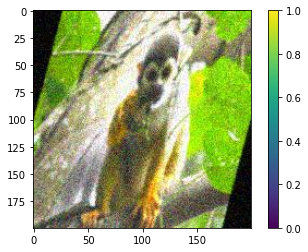

In [ ]:
#Corroboremos que sí cargaron las imagenes transformadas
plt.figure()
plt.imshow(t_X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
#Se agregará a las imagenes de entrenamiento originales y transformadas en un mismo np.array
t_X_train_def=list(X_train)
for index_img in range(0,t_X_train.shape[0]):
    t_X_train_def.append(t_X_train[index_img])
t_X_train_def=np.array(t_X_train_def)
print(t_X_train_def.shape,t_y_train.shape)     #Corroborar que sí se agregaron las imagenes y se mantienen las dimensiones iniciales.

(939, 200, 200, 3) (939,)


##### Validación.

In [ ]:
GAUSSIAN_BLUR_SIGMA_RANGE = 1.0  # Rango de la desviación estándar del desenfoque gaussiano.
GAUSSIAN_NOISE_VARIANCE_RANGE = 0.01  # Rango de la varianza del ruido gaussiano.
ROTATION_RANGE = 30
BRIGHTNESS_RANGE = (0.5, 1.5)
SHEAR_RANGE = 30.0

#LABELS DE VALIDACION
t_y_valid=y_valid

#Estructura de nuestro IMAGE GENERATOR
datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        brightness_range=BRIGHTNESS_RANGE,
        #height_shift_range=0.2,
        shear_range=SHEAR_RANGE,
        #channel_shift_range=CHANNEL_SHIFT_RANGE,        
        preprocessing_function=lambda image: apply_custom_transformations(
            image, gaussian_blur_sigma_range=GAUSSIAN_BLUR_SIGMA_RANGE,
            gaussian_noise_variance_range=GAUSSIAN_NOISE_VARIANCE_RANGE
        ),
        #zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='constant')

i = 0
num_image=60        #Numero de imagenes transformadas
for batch in datagen.flow(X_valid,
                        batch_size=1,
                        save_prefix="t_monkey",
                        #save_to_dir='./transformed_valid_img/',     #Creen una carpeta con las imágenes transformadas
                        #Para drive.
                        save_to_dir='/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_valid_img',
                        
                        save_format='jpg'  #Revisar el formato de las imagenes de sus datasets. En este caso son jpg.
                        ):
    t_y_valid=np.append(t_y_valid,y_valid[i])       #Agregar los labels de las imagenes que se están añadiendo.
    i += 1
    if i > num_image: 
        break  # Sino se especifica un break. Generará imagenes infinitamente
t_y_train.shape       #Observe que sí aumenta de tamaño

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  app.launch_new_instance()


(939,)

In [ ]:
#Cargar las imagenes de transformadas de entrenamiento.
#T_PATH="./transformed_valid_img/"   #Ubicación de la carpeta de las imagenes transformadas.
#Para drive.
T_PATH="/content/drive/MyDrive/Universidad Nacional de Colombia/2022 - 1/MONITORIAS IA/Taller7_RN_CNN/transformed_valid_img"   #Ubicación de la carpeta de las imagenes transformadas.
def create_data():
  training_data = []
  i=0   #Index de las imágenes

  path = os.path.join(T_PATH)  # crea ruta a carpetas con las clases
  for img in tqdm(os.listdir(path)): # itera sobre cada imagen de cada categoria
    img_array = cv2.imread(os.path.join(path, img))  #Cargar la imagen  
    img_array = cv2.resize(img_array,dsize=(200,200),interpolation=cv2.INTER_CUBIC)   #la interpolación indica 
                                                                                        #el método en que se va
                                                                                        #a reducir el tamaño.                                                                                 
    training_data.append([img_array])  # agrega el par [imagen, etiqueta] a los datos de entrenamiento
  
  shuffle(training_data)
  return training_data

t_valid_data=create_data()    #Cargar las imagenes en la carpeta

#Convirtiendolos en un np.array
t_X_valid= np.array(t_valid_data)
print(t_X_valid.shape,X_valid.shape)   #Notemos que el tamaño tiene 5 componentes, así que se ajustará a la shape de los datos iniciales.
t_X_valid=np.reshape(t_X_valid,(t_X_valid.shape[0],200,200,3))
t_X_valid=t_X_valid/255   #Normalizar

100%|██████████| 61/61 [00:00<00:00, 234.15it/s]

(61, 1, 200, 200, 3) (272, 200, 200, 3)


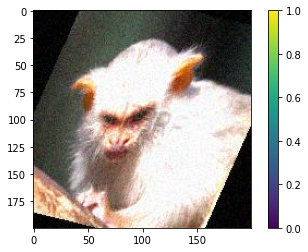

In [ ]:
#Corroboremos que sí cargaron las imagenes transformadas
plt.figure()
plt.imshow(t_X_valid[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
#Se agregará a las imagenes de entrenamiento originales y transformadas en un mismo np.array
t_X_valid_def=list(X_valid)
for index_img in range(0,t_X_valid.shape[0]):
    t_X_valid_def.append(t_X_valid[index_img])
t_X_valid_def=np.array(t_X_valid_def)
print(t_X_valid_def.shape,t_y_valid.shape)     #Corroborar que sí se agregaron las imagenes y se mantienen las dimensiones iniciales.

(333, 200, 200, 3) (333,)


#### 2. Del dataset de entrenamiento se usará 65% para entrenar el modelo y 35% para validar los datos y el dataset de validación será usado para datos de prueba.

In [ ]:
#Separacion de los datos
t_X_test_def=t_X_valid_def
t_y_test=t_y_valid

# Dividimos los datos para entrenamiento y prueba
t_X_train_def, t_X_valid_def, t_y_train, t_y_valid = train_test_split(t_X_train_def, t_y_train,
                                                    test_size = 0.35, #65% datos de entrenamiento, 35% prueba
                                                    stratify = t_y_train)

#Observar los tamaños de datasets con la particion dada.
print(t_X_train_def.shape,t_X_valid_def.shape,t_X_test_def.shape)

#GUARDAR, para evitar hacer todo el procesamiento de datos anterior.

#Se los guardará en la misma carpeta donde estén corriendo el cuaderno.
np.save('t_X_train.npy', t_X_train_def)
np.save('t_y_train.npy', t_y_train)
np.save('t_X_valid.npy', t_X_valid_def)
np.save('t_y_valid.npy', t_y_valid)
np.save('t_X_test.npy', t_X_test_def)
np.save('t_y_test.npy', t_y_test)

(396, 200, 200, 3) (214, 200, 200, 3) (329, 200, 200, 3)


#### **Aplicación del modelo usando todo lo anterior**

In [ ]:
#Nombre de las especies de monos a clasificar
names=['alouatta_palliata','erythrocebus_patas','cacajao_calvus','macaca_fuscata','cebuella_pygmea','cebus_capucinus',
'mico_argentatus','saimiri_sciureus','aotus_nigriceps','trachypithecus_johnii']

#Uso del callback y balanceo
model_CNN = keras.Sequential([
    keras.layers.Input(shape=(200,200,3)),     
    #Caracterizacion de las imagenes
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), 
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),   

    #Etapa de clasificacion
    keras.layers.Flatten(),     #Aplanar los datos a un vector unidimensional
    keras.layers.Dense(64, activation=tf.nn.relu),#Implementza la operación f(z)
    keras.layers.Dense(len(names), activation=tf.nn.softmax)
])
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Utilización de los datos transformados.
history_relu = model_CNN.fit(t_X_train_def,t_y_train,
                    validation_data=(t_X_valid_def, t_y_valid),
                    class_weight=dict(enumerate(class_weights)),    #Uso de balanceo.
                    callbacks=callbacks,        #Uso del callback.
                    epochs=9)

Epoch 1/9
13/13 [==============================] - ETA: 0s - loss: 3.1419 - accuracy: 0.1338
Epoch 1: val_loss did not improve from 1.39589
13/13 [==============================] - 7s 496ms/step - loss: 3.1419 - accuracy: 0.1338 - val_loss: 2.2923 - val_accuracy: 0.1262 - lr: 0.0010
Epoch 2/9
12/13 [==========================>...] - ETA: 0s - loss: 2.2541 - accuracy: 0.1562
Epoch 2: val_loss did not improve from 1.39589
13/13 [==============================] - 5s 390ms/step - loss: 2.2499 - accuracy: 0.1540 - val_loss: 2.1999 - val_accuracy: 0.2009 - lr: 0.0010
Epoch 3/9
13/13 [==============================] - ETA: 0s - loss: 2.0606 - accuracy: 0.2323
Epoch 3: val_loss did not improve from 1.39589
13/13 [==============================] - 4s 366ms/step - loss: 2.0606 - accuracy: 0.2323 - val_loss: 2.0722 - val_accuracy: 0.3224 - lr: 0.0010
Epoch 4/9
13/13 [==============================] - ETA: 0s - loss: 1.7308 - accuracy: 0.4091
Epoch 4: val_loss did not improve from 1.39589
13/13 [=

In [ ]:
#Con el callback se guardó el modelo obtenido
#Libreria necesaria para cargar el modelo
from keras.models import load_model, Model

#Se aprovecha el uso del callback para cargar nuestro modelo entrenado
model_CNN = load_model(os.path.join(OUTPUT_DIRS["/models"], f"{MODEL_NAME}.hdf5"))

Confusion Matrix


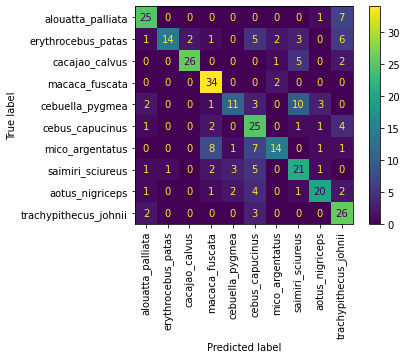

In [ ]:
#Datos de prueba.
predictions=model_CNN.predict(t_X_test_def)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(t_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=names)
disp.plot(xticks_rotation='vertical', values_format='d')

In [ ]:
#Metricas para examinar el modelo bajo datos transformados.
predictions=model_CNN.predict(t_X_test_def)
decoded_predictions = predictions.argmax(axis=1)

print(f'Reporte de clasificación:')
print(classification_report(t_y_test,decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        33
           1       0.93      0.41      0.57        34
           2       0.93      0.76      0.84        34
           3       0.69      0.94      0.80        36
           4       0.65      0.37      0.47        30
           5       0.48      0.74      0.58        34
           6       0.74      0.44      0.55        32
           7       0.51      0.62      0.56        34
           8       0.74      0.65      0.69        31
           9       0.54      0.84      0.66        31

    accuracy                           0.66       329
   macro avg       0.70      0.65      0.65       329
weighted avg       0.70      0.66      0.65       329



**RECORDAR: Reflexión de las redes neuronales**

*En la práctica las redes neuronales artificiales son tratadas como cajas negras, puesto que estudiarlas para descubrir lo que han aprendido durante su proceso de entrenamiento no es una tarea trivial. No obstante, la situación para las CNN es un poco distinta, pues existen técnicas para obtener información visual sobre en qué tipo de características de una imagen se está fijando una CNN durante la inferencia.*

*A pesar de que el modelo en cuestión ha demostrado tener un rendimiento superior, aún no hay certeza de si este se está fijando en las características apropiadas de una imagen. Para compensar esto, usando la técnica Grad-CAM se calculará el mapa de calor asociado a varias imágenes escogidas al azar del conjunto de prueba. El mapa de calor representará mediante colores el nivel de importancia que el modelo le está asignando a cada zona de una imagen para realizar la predicción. La siguiente figura ofrece una idea del significado de cada color:*

<br>
<img src="https://i.ibb.co/ZG5G6Xw/descarga.png" alt="Guía de colores para los mapas de calor" width="700" height="80"*